# Load data

In [ ]:
from google.colab import files

# Load unzipped json
uploaded = files.upload()

Saving atis_intents.csv to atis_intents.csv


In [ ]:
import pandas as pd
import io
import numpy as np

In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['atis_intents.csv']), header=None)
df = df.rename(columns={0: 'class', 1: 'question'})
print(df)

                 class                                           question
0          atis_flight   i want to fly from boston at 838 am and arriv...
1          atis_flight   what flights are available from pittsburgh to...
2     atis_flight_time   what is the arrival time in san francisco for...
3         atis_airfare            cheapest airfare from tacoma to orlando
4         atis_airfare   round trip fares from pittsburgh to philadelp...
...                ...                                                ...
4973      atis_airfare   what is the airfare for flights from denver t...
4974       atis_flight   do you have any flights from denver to baltim...
4975      atis_airline          which airlines fly into and out of denver
4976       atis_flight   does continental fly from boston to san franc...
4977       atis_flight   is there a delta flight from denver to san fr...

[4978 rows x 2 columns]


In [ ]:
mask = np.random.rand(len(df)) < 0.9

training_set = df[mask]
training_set = [v for k, v in training_set.to_dict(orient='index').items()]
testing_set = df[~mask]
testing_set = [v for k, v in testing_set.to_dict(orient='index').items()]

classes = list(set(df['class']))
n_targets = len(classes)

class_map = {v: i for i, v in enumerate(classes)}
inv_class_map = {v: k for k, v in class_map.items()}

# Load pre-trained LM

In [ ]:
!pip install sentence_transformers

     |████████████████████████████████| 92kB 9.5MB/s 
     |████████████████████████████████| 2.5MB 38.9MB/s 
     |████████████████████████████████| 1.2MB 56.2MB/s 
     |████████████████████████████████| 901kB 53.4MB/s 
     |████████████████████████████████| 3.3MB 53.7MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.0.0-cp37-none-any.whl size=126711 sha256=47ce2446a85b88fb6cc532d7a1183fcc5b410c848dd3688372052e9e15aec7e1
  Stored in directory: /root/.cache/pip/wheels/38/d2/98/d191289a877a34c68aa67e05179521e060f96394a3e9336be6
Successfully built sentence-transformers
ERROR: transformers 4.8.2 has requirement huggingface-hub==0.0.12, but you'll have huggingface-hub 0.0.13 which is incompatible.


In [ ]:
from sentence_transformers import SentenceTransformer

sentence_model = SentenceTransformer('paraphrase-distilroberta-base-v1').cuda()

In [ ]:
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.', 
    'The quick brown fox jumps over the lazy dog.']
sentence_embeddings = sentence_model.encode(sentences)

# Check that it's all working
print(sentence_embeddings.shape)

(3, 768)


# JAX based classifier

In [ ]:
import time

import jax.numpy as jnp

from jax import grad, jit, vmap, value_and_grad
from jax import random

from jax.scipy.special import logsumexp
from jax.experimental import optimizers

from torch.utils import data

In [ ]:
class SentenceDataset(data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data = self.dataset[idx]

        return data['question'], class_map[data['class']]


def numpy_collate(batch):
    sentences = [i[0] for i in batch]
    labels = np.array([i[1] for i in batch])

    sentence_embeddings = sentence_model.encode(sentences)
    
    return sentence_embeddings, labels


class SentenceLoader(data.DataLoader):
    def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
        super(self.__class__, self).__init__(dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            batch_sampler=batch_sampler,
            num_workers=num_workers,
            collate_fn=numpy_collate,
            pin_memory=pin_memory,
            drop_last=drop_last,
            timeout=timeout,
            worker_init_fn=worker_init_fn)

In [ ]:
def relu(x):
    return jnp.maximum(0, x)

def predict(params, image):
  # per-example predictions
    activations = image
    for w, b in params[:-1]:
        outputs = jnp.dot(w, activations) + b
        activations = relu(outputs)
  
    final_w, final_b = params[-1]
    logits = jnp.dot(final_w, activations) + final_b
    return logits - logsumexp(logits)

batched_predict = vmap(predict, in_axes=(None, 0))

In [ ]:
def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[:, None] == jnp.arange(k), dtype)
  
def accuracy(params, images, targets):
    target_class = jnp.argmax(targets, axis=1)
    predicted_class = jnp.argmax(batched_predict(params, images), axis=1)
    return jnp.mean(predicted_class == target_class)

def loss(params, images, targets):
    preds = batched_predict(params, images)
    return -jnp.mean(preds * targets)

@jit
def update(i, params, x, y, opt_state):
    grads = grad(loss)(params, x, y)
    opt_state = opt_update(i, grads, opt_state)
    return get_params(opt_state), opt_state

In [ ]:
# Get the full train dataset (for checking accuracy while training)
train_sentences = [i['question'] for i in training_set]
train_sentences = sentence_model.encode(train_sentences)
train_labels = [i['class'] for i in training_set]
train_labels = np.array([class_map[i] for i in train_labels])
train_labels = one_hot(train_labels, n_targets)

### PCA

In [ ]:
import matplotlib.pyplot as plt
from ipywidgets import widgets, interactive
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
train_pca = PCA(n_components=2).fit_transform(train_sentences)
train_tsne = TSNE(n_components=2).fit_transform(train_sentences)

In [ ]:
graph_type = widgets.Dropdown(options=['TSNE', 'PCA'], value='PCA', description='Plot:')

def draw_fn(graph_type):
    plt.figure(figsize=(8, 8))
    if graph_type == 'PCA':
        colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'gray', 'orange', 'purple', 'brown', 'pink'
        for c, label in zip(colors, classes):
            points = [i for i, v in enumerate(training_set) if v['class'] == label]
            plt.scatter(train_pca[points, 0], train_pca[points, 1], c=c, label=label)
        plt.legend()
    elif graph_type == 'TSNE':
        colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'gray', 'orange', 'purple', 'brown', 'pink'
        for c, label in zip(colors, classes):
            points = [i for i, v in enumerate(training_set) if v['class'] == label]
            plt.scatter(train_tsne[points, 0], train_tsne[points, 1], c=c, label=label)
        plt.legend()
    plt.show()

interactive(draw_fn, graph_type=graph_type)

interactive(children=(Dropdown(description='Plot:', index=1, options=('TSNE', 'PCA'), value='PCA'), Output()),…

### Classifier training

In [ ]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [768, 128, n_targets]
step_size = 0.001
num_epochs = 20
batch_size = 64

In [ ]:
training_dataset = SentenceDataset(training_set)
training_generator = SentenceLoader(training_dataset, shuffle=True, batch_size=batch_size, num_workers=0)

In [ ]:
params = init_network_params(layer_sizes, random.PRNGKey(42))
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

for epoch in range(num_epochs):
    start_time = time.time()
    for x, y in training_generator:
        y = one_hot(y, n_targets)
        params, opt_state = update(epoch, get_params(opt_state), x, y, opt_state)
    epoch_time = time.time() - start_time

    train_acc = accuracy(get_params(opt_state), train_sentences, train_labels)
    print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
    print("Training set accuracy {}".format(train_acc))

Epoch 0 in 4.54 sec
Training set accuracy 0.882815957069397
Epoch 1 in 3.56 sec
Training set accuracy 0.9044084548950195
Epoch 2 in 3.38 sec
Training set accuracy 0.9120557308197021
Epoch 3 in 3.44 sec
Training set accuracy 0.9228519797325134
Epoch 4 in 3.41 sec
Training set accuracy 0.9304993152618408
Epoch 5 in 3.46 sec
Training set accuracy 0.9370220303535461
Epoch 6 in 3.51 sec
Training set accuracy 0.9417453408241272
Epoch 7 in 3.55 sec
Training set accuracy 0.9435447454452515
Epoch 8 in 3.52 sec
Training set accuracy 0.9455690383911133
Epoch 9 in 3.53 sec
Training set accuracy 0.9496176242828369
Epoch 10 in 3.50 sec
Training set accuracy 0.9518668055534363
Epoch 11 in 3.51 sec
Training set accuracy 0.9561403393745422
Epoch 12 in 3.47 sec
Training set accuracy 0.9599639773368835
Epoch 13 in 3.49 sec
Training set accuracy 0.9642375111579895
Epoch 14 in 3.48 sec
Training set accuracy 0.9662618041038513
Epoch 15 in 3.49 sec
Training set accuracy 0.9691857695579529
Epoch 16 in 3.54 se

# Get worst performing test points

In [ ]:
testing_sentences = [i['question'] for i in testing_set]
testing_sentences = sentence_model.encode(testing_sentences)
testing_labels = [i['class'] for i in testing_set]
testing_labels = np.array([class_map[i] for i in testing_labels])

predicted_class = jnp.argmax(batched_predict(params, testing_sentences), axis=1)
logprob = batched_predict(params, testing_sentences)
pred_prob = jnp.exp(logprob)

In [ ]:
wrong_indices = [i for i, x in enumerate(testing_labels != predicted_class) if x]
print(wrong_indices)

[27, 35, 44, 60, 82, 93, 122, 132, 138, 188, 200, 219, 236, 238, 264, 271, 310, 363, 398, 407, 413, 467, 473, 475, 494, 514]


# Calculate influence functions

In [ ]:
import jax

from jax import jvp
from jax.tree_util import tree_flatten, tree_leaves


def hvp(params, x, t, v):
    loss_fn = lambda params: loss(params, x, t)
    return jvp(grad(loss_fn), (params,), (v,))[1]


def single_loss(params, sentence, targets):
    preds = predict(params, sentence)
    return -jnp.mean(preds * targets)

@jit
def lissa_estimate(params, x, t, v, h_estimate, damp=0.01, scale=25):
    # Recursively caclulate h_estimate
    hv = hvp(params, x, t, h_estimate)
    h_estimate = jax.tree_multimap(lambda x, y, z: x + (1 - damp) * y - z / scale, v, h_estimate, hv)
    return h_estimate


def get_s_test(z_test, t_test, params, z_loader, damp=0.01, scale=25.0,
               recursion_depth=5000):
    v = grad(single_loss)(params, z_test, t_test)
    h_estimate = v.copy()
    for depth in range(recursion_depth):
        x, t = next(iter(z_loader))
        t = one_hot(t, n_targets)
        h_estimate = lissa_estimate(params, x, t, v, h_estimate,
                                    damp=damp, scale=scale)

        if depth % 500 == 0:
            print("Calc. s_test recursions: ", depth, recursion_depth)

    return h_estimate

### Pick from an incorrect prediction

In [ ]:
idx = 2

testing_id = wrong_indices[idx]
print("Testing id:", testing_id)

Testing id: 44


In [ ]:
label_class = class_map[testing_set[testing_id]['class']]
print("Sentence:", testing_set[testing_id]['question'])
print("True label:", testing_set[testing_id]['class'])
print("True label prob:", pred_prob[testing_id][label_class])
print("Predicted label:", inv_class_map[int(predicted_class[testing_id])])
print("Predicted prob:", jnp.max(pred_prob[testing_id]))

Sentence:  i would like the time of all flights from san francisco to pittsburgh on sunday
True label: atis_flight_time
True label prob: 0.2230697
Predicted label: atis_flight
Predicted prob: 0.7629005


In [ ]:
print(testing_set[testing_id]['class'])
print(class_map[testing_set[testing_id]['class']])
print(testing_labels[testing_id])

atis_flight_time
10
10


### Get s_test by calculating the hvp

In [ ]:
z_loader = SentenceLoader(training_dataset, shuffle=True, batch_size=1, num_workers=0)

s_test = get_s_test(testing_sentences[testing_id], testing_labels[testing_id], params, z_loader)

Calc. s_test recursions:  0 5000
Calc. s_test recursions:  500 5000
Calc. s_test recursions:  1000 5000
Calc. s_test recursions:  1500 5000
Calc. s_test recursions:  2000 5000
Calc. s_test recursions:  2500 5000
Calc. s_test recursions:  3000 5000
Calc. s_test recursions:  3500 5000
Calc. s_test recursions:  4000 5000
Calc. s_test recursions:  4500 5000


### Get influence score for all training data

In [ ]:
from functools import partial

z_loader = SentenceLoader(training_dataset, shuffle=False, batch_size=8, num_workers=0)

@jit
def get_influence(x, t, params, s_test):
    grad_z_vec = grad(single_loss)(params, x, t)
    tmp_influence = jax.tree_multimap(lambda x, y: x * y, grad_z_vec, s_test)
    tmp_influence = -np.sum([jnp.sum(i) for i in tree_leaves(tmp_influence)]) / len(training_set)
    return tmp_influence

influences = []
for i, (x, t) in enumerate(z_loader):
    t = one_hot(t, n_targets)
    z = [i for i in zip(x, t)]
    tmp_influence = vmap(partial(get_influence, params=params, s_test=s_test), in_axes=(0, 0))(x, t)
    influences.extend(tmp_influence)
    if i % 50 == 0:
        print(i)

not_helpful = np.argsort(influences)
helpful = not_helpful[::-1]

0
50
100
150
200
250
300
350
400
450
500
550


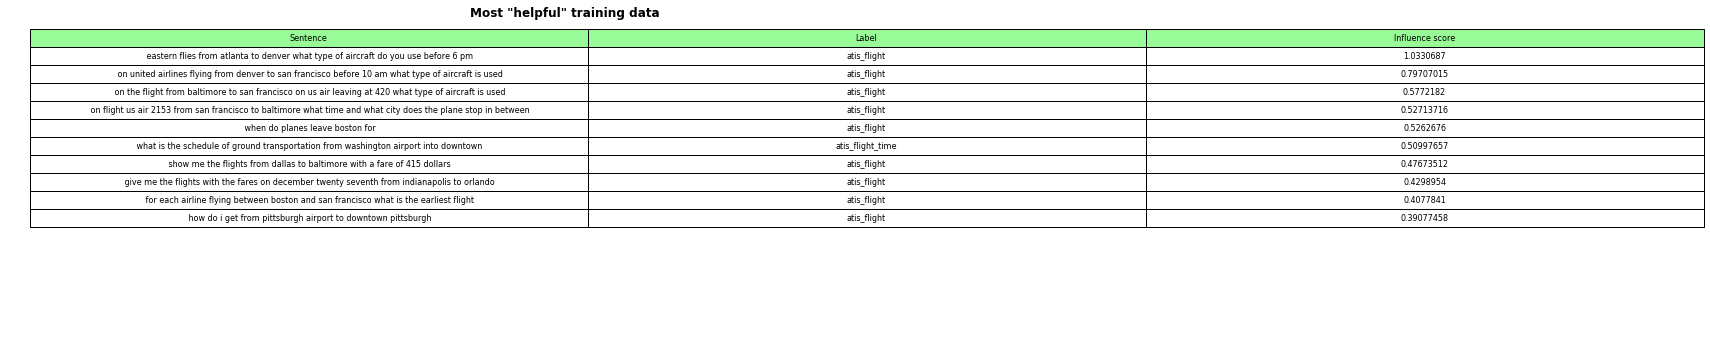

In [ ]:
col_labels = ["Sentence", "Label", "Influence score"]

sentences = [training_set[i]['question'] for i in helpful[:10]]
labels = [training_set[i]['class'] for i in helpful[:10]]
influence_scores = [influences[i] for i in helpful[:10]]
cell_text = [[i, j, k] for i, j, k in zip(sentences, labels, influence_scores)]

fig2, ax2 = plt.subplots(figsize=(20,6))
ax2.set_axis_off()
table2 = ax2.table(
    cellText = cell_text,
    colLabels = col_labels,
    colColours =["palegreen"] * 3,
    cellLoc ='center',
    loc ='upper left',
)
table2.set_fontsize(18)
table2.scale(1.5, 1.5)

ax2.set_title('Most "helpful" training data',
             fontweight ="bold")

plt.show()

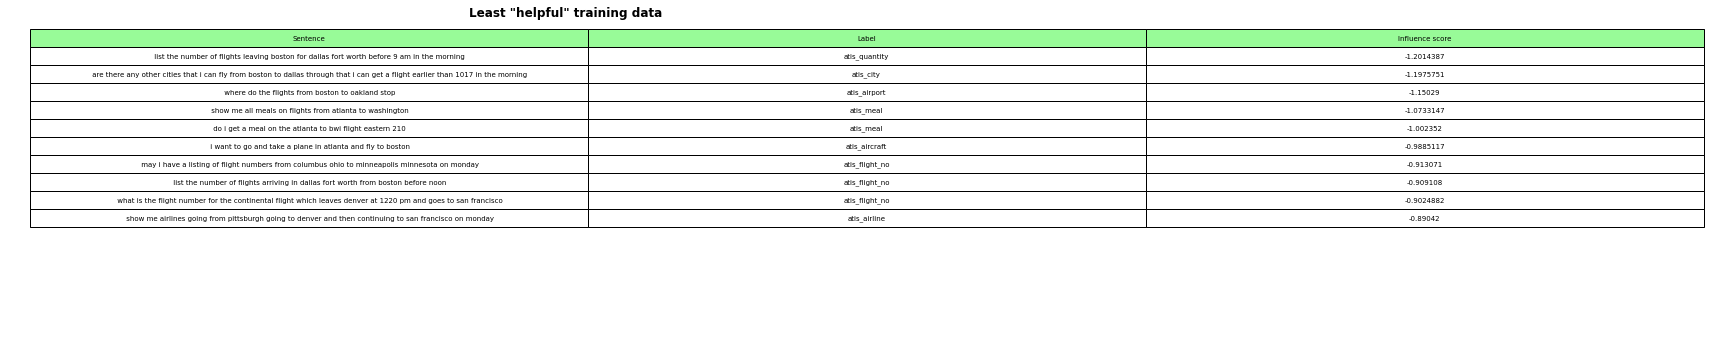

In [ ]:
sentences = [training_set[i]['question'] for i in not_helpful[:10]]
labels = [training_set[i]['class'] for i in not_helpful[:10]]
influence_scores = [influences[i] for i in not_helpful[:10]]
cell_text = [[i, j, k] for i, j, k in zip(sentences, labels, influence_scores)]

fig, ax = plt.subplots(figsize=(20,6))
ax.set_axis_off()
table = ax.table(
    cellText = cell_text,
    colLabels = col_labels,
    colColours =["palegreen"] * 3,
    cellLoc ='center',
    loc ='upper left',
)
table.set_fontsize(14)
table.scale(1.5, 1.5)

ax.set_title('Least "helpful" training data',
             fontweight ="bold")

plt.show()

In [ ]:
comb_set = np.concatenate((train_sentences, [testing_sentences[idx]]))

l2_dist = jnp.linalg.norm(testing_sentences[idx] - train_sentences, axis=1)
tsne_plot_data = TSNE(n_components=2).fit_transform(comb_set)
pca_plot_data = PCA(n_components=2).fit_transform(comb_set)

In [ ]:
graph_type = widgets.Dropdown(
    options=['Influence', 'TSNE', 'PCA'],
    value='Influence',
    description='Plot:',
)
influences_np = np.array(influences)
l2_dist_np = np.array(l2_dist)

def draw_fn(graph_type):
    plt.figure(figsize=(8, 8))
    if graph_type == "Influence":
        colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'gray', 'orange', 'purple', 'brown', 'pink'
        for c, label in zip(colors, classes):
            points = [i for i, v in enumerate(training_set) if v['class'] == label]
            plt.scatter(l2_dist_np[points], influences_np[points], c=c, label=label)
        plt.legend()
        plt.xlabel('L2 distance')
        plt.ylabel('Influence score')
    elif graph_type == 'TSNE':
        fig, ax = plt.subplots(figsize=(8, 8))
        colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'gray', 'orange', 'purple', 'brown', 'pink'
        for c, label in zip(colors, classes):
            points = [i for i, v in enumerate(training_set) if v['class'] == label]
            ax.scatter(tsne_plot_data[points, 0], tsne_plot_data[points, 1], c=c, label=label)
        ax.annotate('Test point', (tsne_plot_data[-1, 0], tsne_plot_data[-1, 1]), backgroundcolor='w')
        plt.legend()
    elif graph_type == 'PCA':
        fig, ax = plt.subplots(figsize=(8, 8))
        colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'gray', 'orange', 'purple', 'brown', 'pink'
        for c, label in zip(colors, classes):
            points = [i for i, v in enumerate(training_set) if v['class'] == label]
            ax.scatter(pca_plot_data[points, 0], pca_plot_data[points, 1], c=c, label=label)
        ax.annotate('Test point', (pca_plot_data[-1, 0], pca_plot_data[-1, 1]), backgroundcolor='w')
        plt.legend()
    plt.show()

interactive(draw_fn, graph_type=graph_type)

interactive(children=(Dropdown(description='Plot:', options=('Influence', 'TSNE', 'PCA'), value='Influence'), …

# Remove unhelpful training data

In [ ]:
new_training_set = [v for i, v in enumerate(training_set) if i not in not_helpful[:10]]

new_training_dataset = SentenceDataset(new_training_set)
new_training_generator = SentenceLoader(new_training_dataset, shuffle=True,
                                        batch_size=batch_size, num_workers=0)

In [ ]:
new_params = params.copy()
new_opt_state = opt_init(new_params)

for epoch in range(5):
    start_time = time.time()
    for x, y in new_training_generator:
        y = one_hot(y, n_targets)
        new_params, new_opt_state = update(epoch, get_params(new_opt_state), x, y, new_opt_state)
    epoch_time = time.time() - start_time

    train_acc = accuracy(get_params(new_opt_state), train_sentences, train_labels)
    print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
    print("Training set accuracy {}".format(train_acc))

Epoch 0 in 3.49 sec
Training set accuracy 0.9822311997413635
Epoch 1 in 3.41 sec
Training set accuracy 0.9887539148330688
Epoch 2 in 3.38 sec
Training set accuracy 0.9905532598495483
Epoch 3 in 3.43 sec
Training set accuracy 0.9914529323577881
Epoch 4 in 3.42 sec
Training set accuracy 0.9923526644706726


In [ ]:
new_predicted_class = jnp.argmax(batched_predict(new_params, testing_sentences), axis=1)
new_logprob = batched_predict(new_params, testing_sentences)
new_pred_prob = jnp.exp(new_logprob)
new_label_class = class_map[testing_set[testing_id]['class']]

print("Sentence:", testing_set[testing_id]['question'])
print("True label:", testing_set[testing_id]['class'])
print("True label prob:", new_pred_prob[testing_id][new_label_class])
print("Predicted label:", inv_class_map[int(new_predicted_class[testing_id])])
print("Predicted prob:", jnp.max(new_pred_prob[testing_id]))

Sentence:  i would like the time of all flights from san francisco to pittsburgh on sunday
True label: atis_flight_time
True label prob: 0.8124418
Predicted label: atis_flight_time
Predicted prob: 0.8124418
